In [3]:
bc_data <- read.table("/home/anasapata/Personal/ProjetoIntegrado/Uso-de-Machine-Learning-para-previs-o-de-doen-as/breast-cancer-wisconsin.data.csv", 
                      header = FALSE, 
                      sep = ",")
colnames(bc_data) <- c("sample_code_number", 
                       "clump_thickness", 
                       "uniformity_of_cell_size", 
                       "uniformity_of_cell_shape", 
                       "marginal_adhesion", 
                       "single_epithelial_cell_size", 
                       "bare_nuclei", 
                       "bland_chromatin", 
                       "normal_nucleoli", 
                       "mitosis", 
                       "classes")

bc_data$classes <- ifelse(bc_data$classes == "2", "benign",
                          ifelse(bc_data$classes == "4", "malignant", NA))

In [4]:
bc_data[bc_data == "?"] <- NA

# how many NAs are in the data
length(which(is.na(bc_data)))

[1] 16

In [5]:
# how many samples would we loose, if we removed them?
nrow(bc_data)

[1] 699

In [6]:
nrow(bc_data[is.na(bc_data), ])

[1] 16

In [7]:
# impute missing data
library(mice)

bc_data[,2:10] <- apply(bc_data[, 2:10], 2, function(x) as.numeric(as.character(x)))
dataset_impute <- mice(bc_data[, 2:10],  print = FALSE)
bc_data <- cbind(bc_data[, 11, drop = FALSE], mice::complete(dataset_impute, 1))

bc_data$classes <- as.factor(bc_data$classes)

# how many benign and malignant cases are there?
summary(bc_data$classes)

Loading required package: lattice


Attaching package: ‘mice’


The following objects are masked from ‘package:base’:

    cbind, rbind




benign malignant 
      458       241

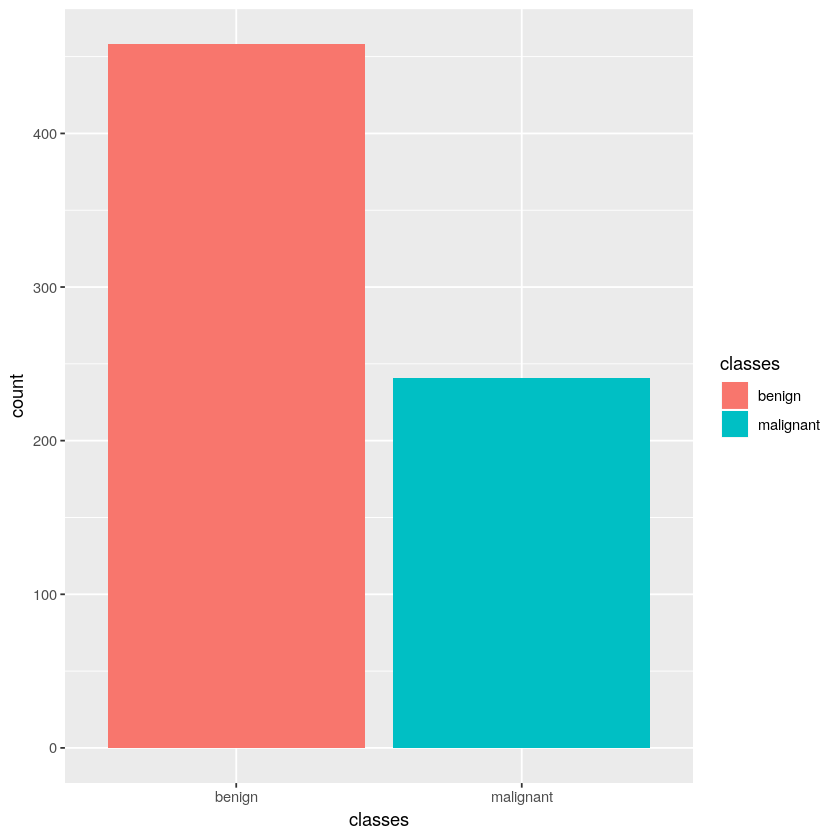

In [8]:
library(ggplot2)

ggplot(bc_data, aes(x = classes, fill = classes)) +
  geom_bar()

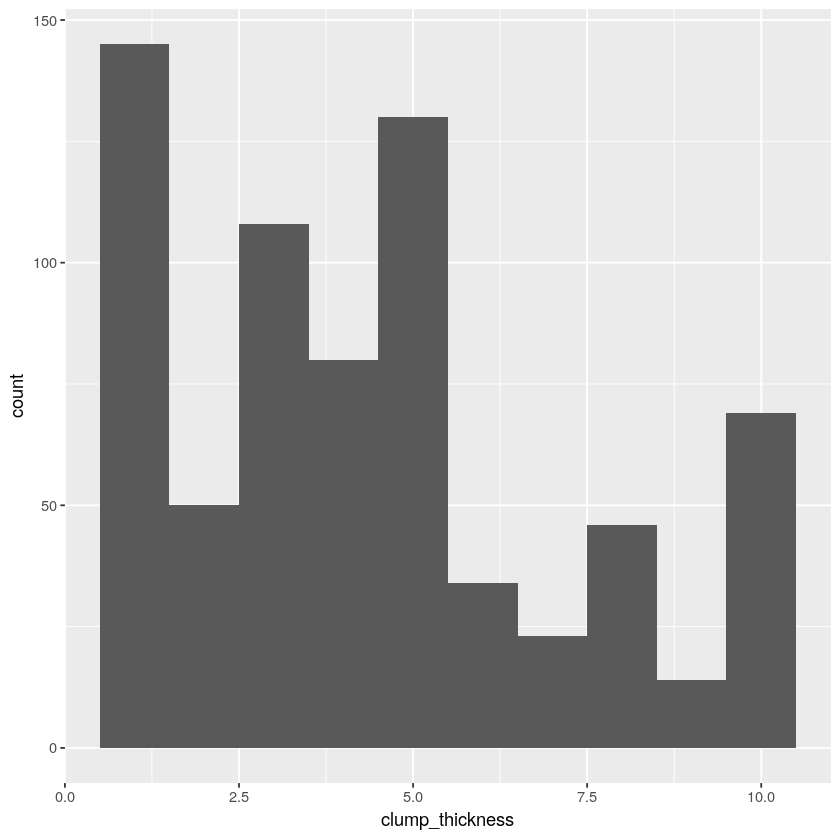

In [9]:
ggplot(bc_data, aes(x = clump_thickness)) +
  geom_histogram(bins = 10)

Loading required package: ellipse


Attaching package: ‘ellipse’


The following object is masked from ‘package:graphics’:

    pairs


Loading required package: Biostrings

Loading required package: BiocGenerics

Loading required package: parallel


Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB


The following objects are masked from ‘package:mice’:

    cbind, rbind


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, basename, cbind, colnames,
    dirname, do.call, duplicated, eval, evalq, Filter, Find, get, grep,
    grepl, intersect, is.unsorted, lapply, Map, mapply, match, mget,
    order, paste, pmax, pmax.int, pmin, pmin.int, P

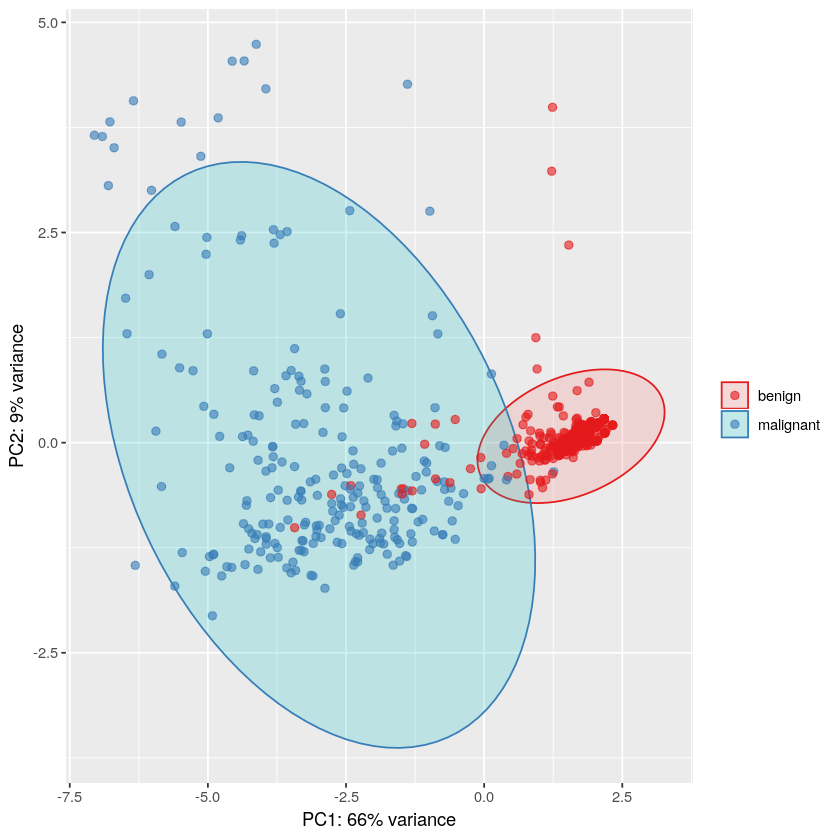

In [10]:
library(pcaGoPromoter)
library(ellipse)

# perform pca and extract scores
pcaOutput <- pca(t(bc_data[, -1]), printDropped = FALSE, scale = TRUE, center = TRUE)
pcaOutput2 <- as.data.frame(pcaOutput$scores)
  
# define groups for plotting
pcaOutput2$groups <- bc_data$classes
  
centroids <- aggregate(cbind(PC1, PC2) ~ groups, pcaOutput2, mean)

conf.rgn  <- do.call(rbind, lapply(unique(pcaOutput2$groups), function(t)
  data.frame(groups = as.character(t),
             ellipse(cov(pcaOutput2[pcaOutput2$groups == t, 1:2]),
                   centre = as.matrix(centroids[centroids$groups == t, 2:3]),
                   level = 0.95),
             stringsAsFactors = FALSE)))
    
ggplot(data = pcaOutput2, aes(x = PC1, y = PC2, group = groups, color = groups)) + 
    geom_polygon(data = conf.rgn, aes(fill = groups), alpha = 0.2) +
    geom_point(size = 2, alpha = 0.6) + 
    scale_color_brewer(palette = "Set1") +
    labs(color = "",
         fill = "",
         x = paste0("PC1: ", round(pcaOutput$pov[1], digits = 2) * 100, "% variance"),
         y = paste0("PC2: ", round(pcaOutput$pov[2], digits = 2) * 100, "% variance")) 


Attaching package: ‘tidyr’


The following object is masked from ‘package:S4Vectors’:

    expand


The following object is masked from ‘package:mice’:

    complete




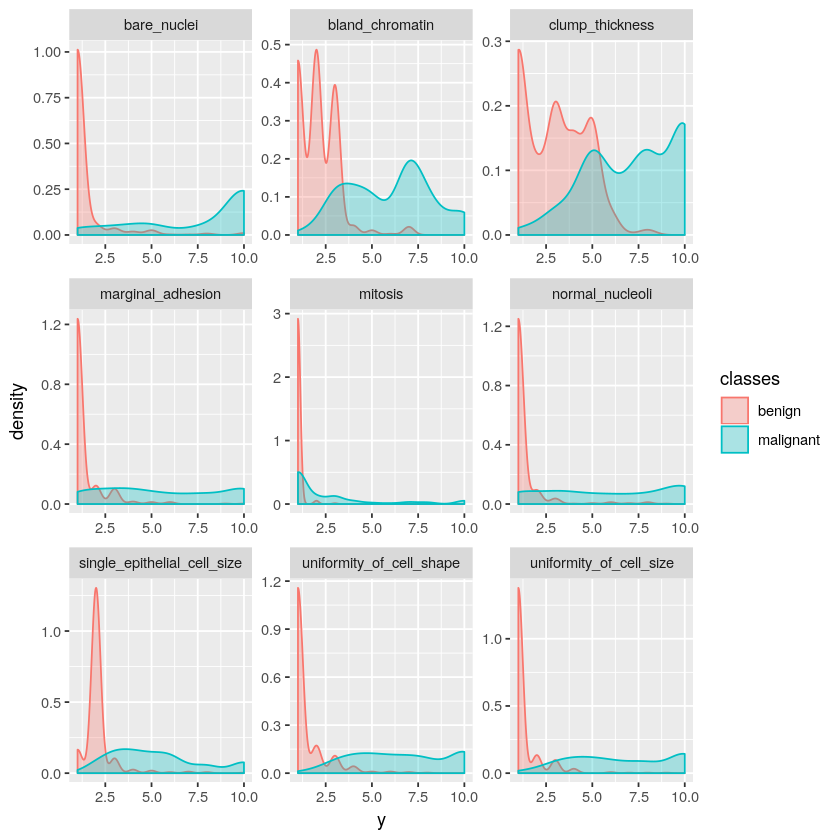

In [11]:
library(tidyr)

gather(bc_data, x, y, clump_thickness:mitosis) %>%
  ggplot(aes(x = y, color = classes, fill = classes)) +
    geom_density(alpha = 0.3) +
    facet_wrap( ~ x, scales = "free", ncol = 3)

In [12]:
# configure multicore
library(doParallel)
cl <- makeCluster(detectCores())
registerDoParallel(cl)

library(caret)

Loading required package: foreach

Loading required package: iterators



In [13]:
set.seed(42)
index <- createDataPartition(bc_data$classes, p = 0.7, list = FALSE)
train_data <- bc_data[index, ]
test_data  <- bc_data[-index, ]


Attaching package: ‘dplyr’


The following objects are masked from ‘package:Biostrings’:

    collapse, intersect, setdiff, setequal, union


The following object is masked from ‘package:XVector’:

    slice


The following objects are masked from ‘package:IRanges’:

    collapse, desc, intersect, setdiff, slice, union


The following objects are masked from ‘package:S4Vectors’:

    first, intersect, rename, setdiff, setequal, union


The following objects are masked from ‘package:BiocGenerics’:

    combine, intersect, setdiff, union


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




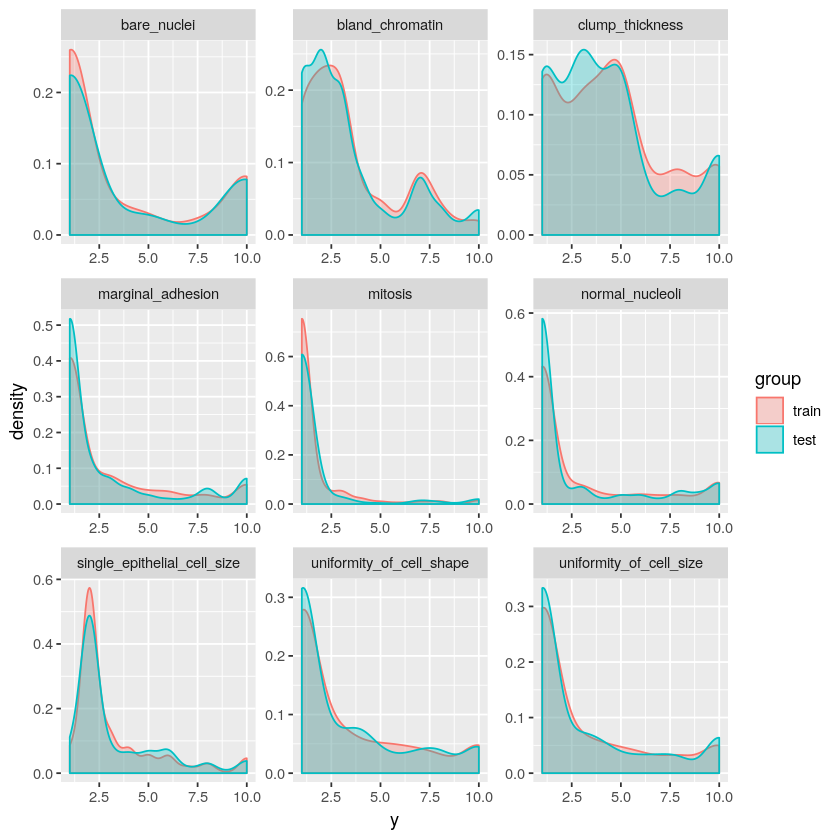

In [14]:
library(dplyr)

rbind(data.frame(group = "train", train_data),
      data.frame(group = "test", test_data)) %>%
  gather(x, y, clump_thickness:mitosis) %>%
  ggplot(aes(x = y, color = group, fill = group)) +
    geom_density(alpha = 0.3) +
    facet_wrap( ~ x, scales = "free", ncol = 3)

In [15]:
set.seed(42)
model_glm <- caret::train(clump_thickness ~ .,
                          data = train_data,
                          method = "glm",
                          preProcess = c("scale", "center"),
                          trControl = trainControl(method = "repeatedcv", 
                                                  number = 10, 
                                                  repeats = 10, 
                                                  savePredictions = TRUE, 
                                                  verboseIter = FALSE))

In [16]:
model_glm

Generalized Linear Model 

490 samples
  9 predictor

Pre-processing: scaled (9), centered (9) 
Resampling: Cross-Validated (10 fold, repeated 10 times) 
Summary of sample sizes: 442, 440, 443, 442, 441, 441, ... 
Resampling results:

  RMSE      Rsquared   MAE     
  1.952455  0.5269895  1.629066


In [17]:
predictions <- predict(model_glm, test_data)

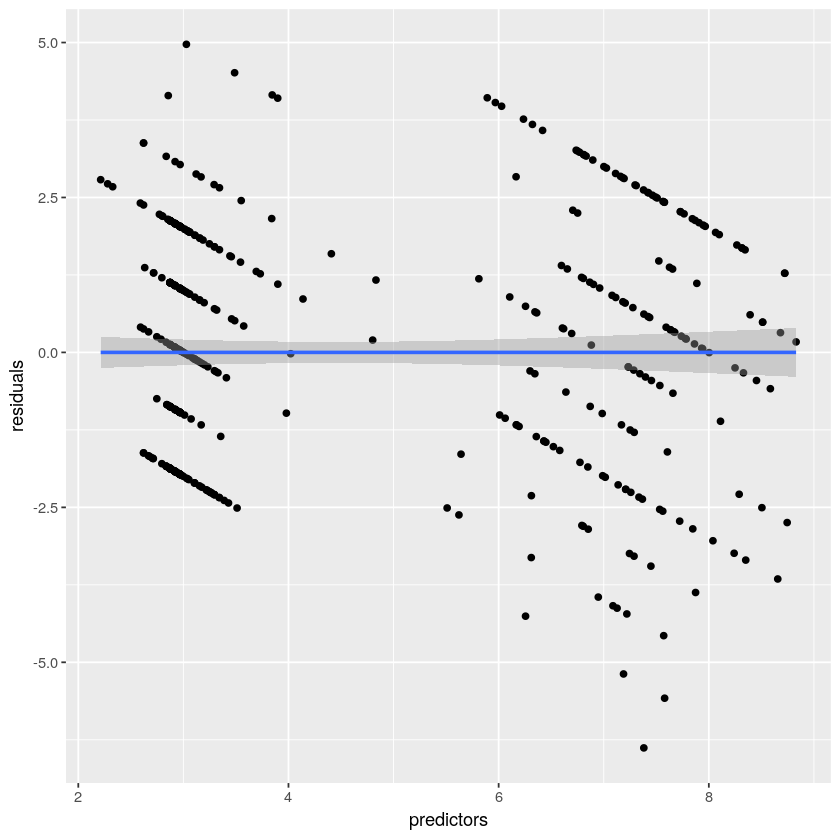

In [18]:
# model_glm$finalModel$linear.predictors == model_glm$finalModel$fitted.values
data.frame(residuals = resid(model_glm),
           predictors = model_glm$finalModel$linear.predictors) %>%
  ggplot(aes(x = predictors, y = residuals)) +
    geom_jitter() +
    geom_smooth(method = "lm")

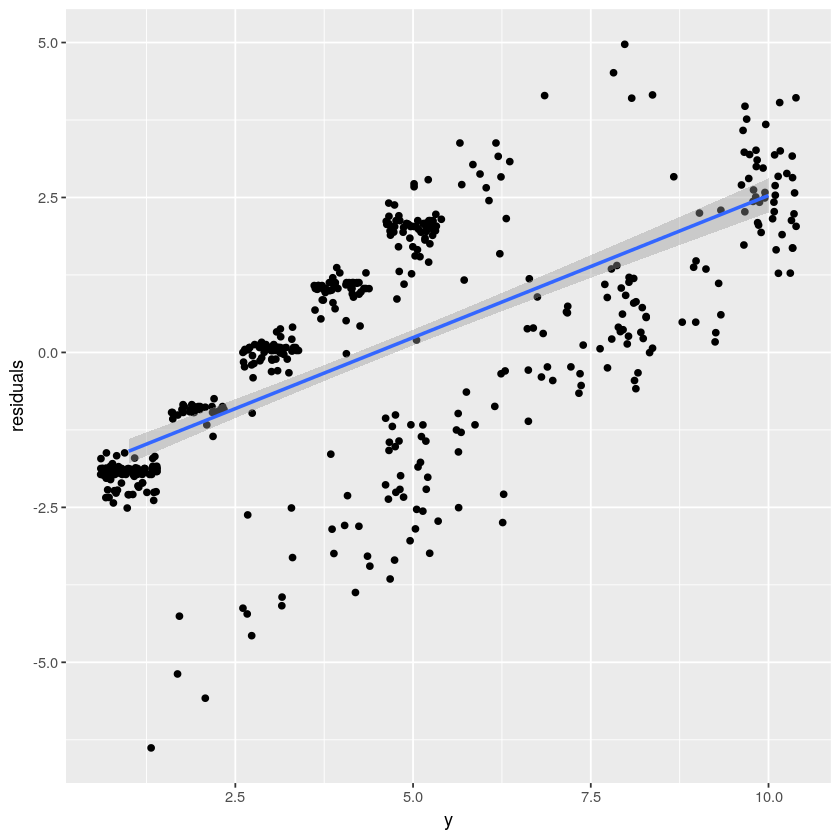

In [19]:
# y == train_data$clump_thickness
data.frame(residuals = resid(model_glm),
           y = model_glm$finalModel$y) %>%
  ggplot(aes(x = y, y = residuals)) +
    geom_jitter() +
    geom_smooth(method = "lm")

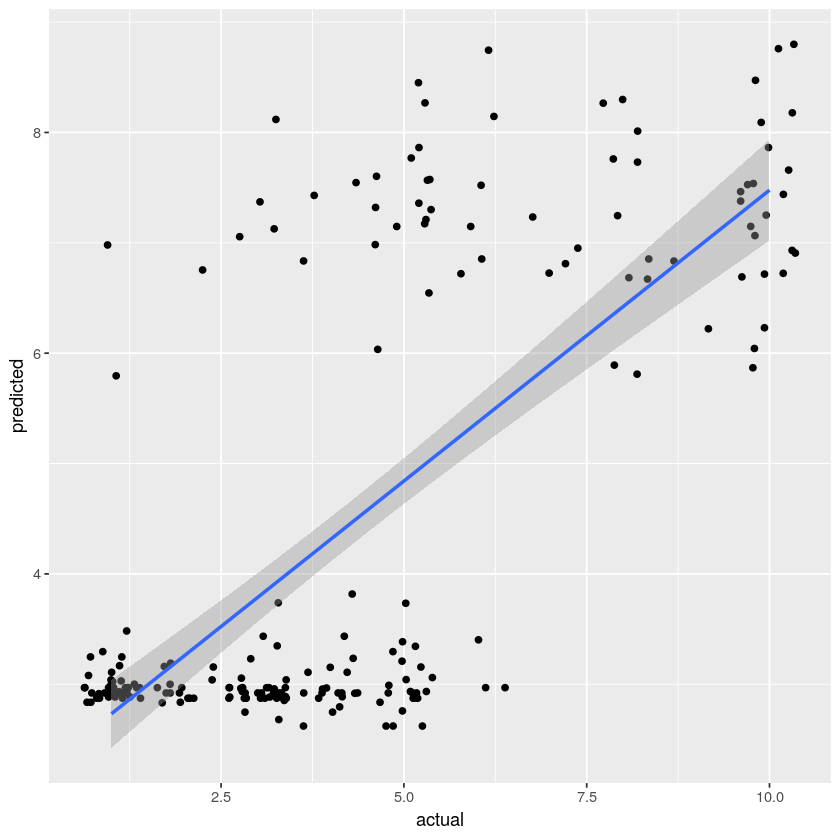

In [20]:
data.frame(actual = test_data$clump_thickness,
           predicted = predictions) %>%
  ggplot(aes(x = actual, y = predicted)) +
    geom_jitter() +
    geom_smooth(method = "lm")

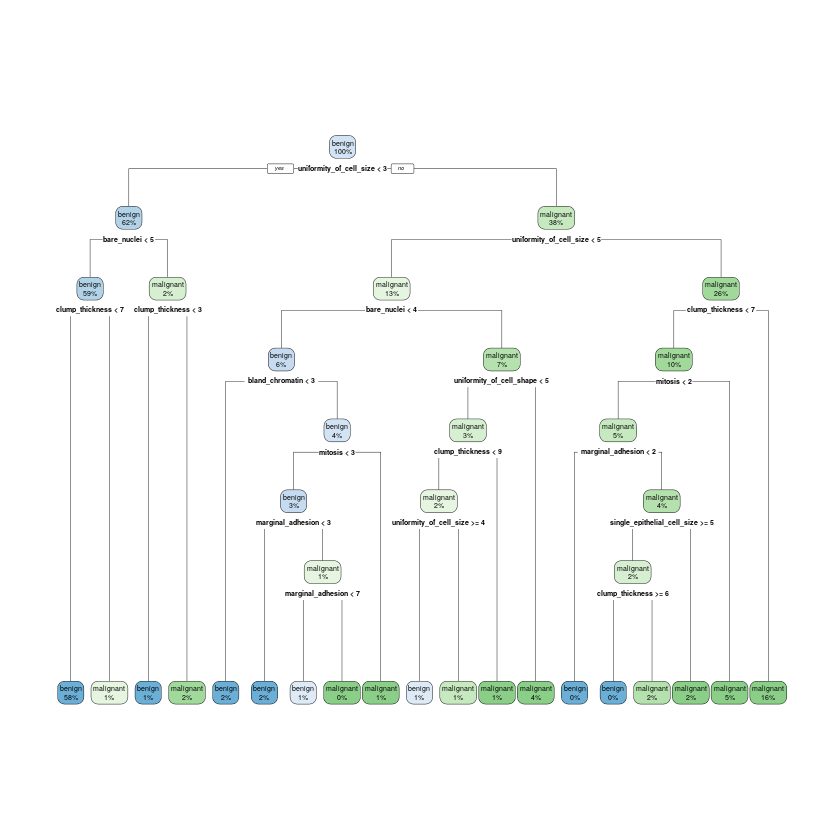

In [21]:
library(rpart)
library(rpart.plot)

set.seed(42)
fit <- rpart(classes ~ .,
            data = train_data,
            method = "class",
            control = rpart.control(xval = 10, 
                                    minbucket = 2, 
                                    cp = 0), 
             parms = list(split = "information"))

rpart.plot(fit, extra = 100)

In [22]:
set.seed(42)
model_rf <- caret::train(classes ~ .,
                         data = train_data,
                         method = "rf",
                         preProcess = c("scale", "center"),
                         trControl = trainControl(method = "repeatedcv", 
                                                  number = 10, 
                                                  repeats = 10, 
                                                  savePredictions = TRUE, 
                                                  verboseIter = FALSE))

In [23]:
model_rf$finalModel$confusion

,benign,malignant,class.error
benign,310,11,0.03426791
malignant,6,163,0.03550296


In [24]:
imp <- model_rf$finalModel$importance
imp[order(imp, decreasing = TRUE), ]

uniformity_of_cell_shape     uniformity_of_cell_size 
                  42.516013                   37.820321 
                bare_nuclei             bland_chromatin 
                  35.888468                   29.547758 
single_epithelial_cell_size             normal_nucleoli 
                  22.756688                   21.926499 
            clump_thickness           marginal_adhesion 
                  16.650403                    9.039894 
                    mitosis 
                   3.202464

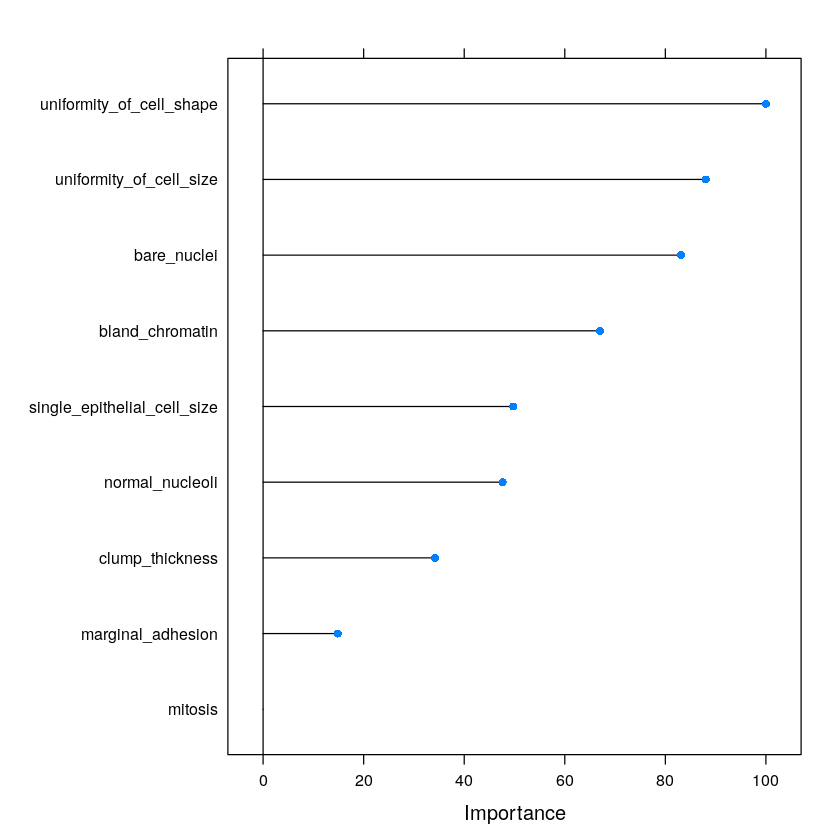

In [25]:
# estimate variable importance
importance <- varImp(model_rf, scale = TRUE)
plot(importance)

In [26]:
confusionMatrix(predict(model_rf, test_data), test_data$classes)

Confusion Matrix and Statistics

           Reference
Prediction  benign malignant
  benign       134         1
  malignant      3        71
                                          
               Accuracy : 0.9809          
                 95% CI : (0.9517, 0.9948)
    No Information Rate : 0.6555          
    P-Value [Acc > NIR] : <2e-16          
                                          
                  Kappa : 0.9579          
                                          
 Mcnemar's Test P-Value : 0.6171          
                                          
            Sensitivity : 0.9781          
            Specificity : 0.9861          
         Pos Pred Value : 0.9926          
         Neg Pred Value : 0.9595          
             Prevalence : 0.6555          
         Detection Rate : 0.6411          
   Detection Prevalence : 0.6459          
      Balanced Accuracy : 0.9821          
                                          
       'Positive' Class : benign          

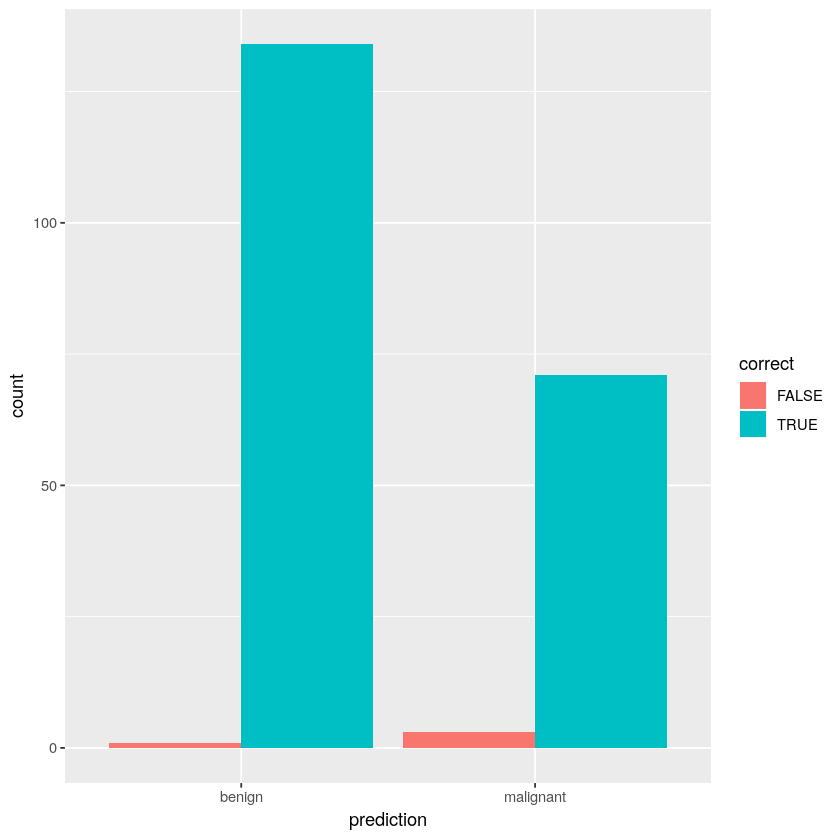

In [27]:
results <- data.frame(actual = test_data$classes,
                      predict(model_rf, test_data, type = "prob"))

results$prediction <- ifelse(results$benign > 0.5, "benign",
                             ifelse(results$malignant > 0.5, "malignant", NA))

results$correct <- ifelse(results$actual == results$prediction, TRUE, FALSE)

ggplot(results, aes(x = prediction, fill = correct)) +
  geom_bar(position = "dodge")

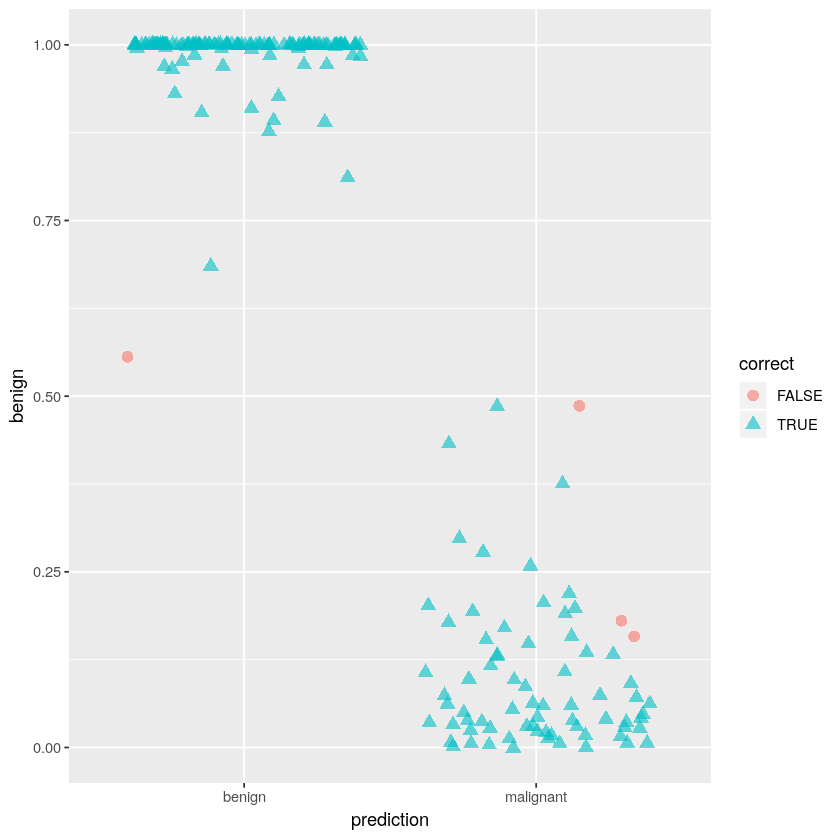

In [28]:
ggplot(results, aes(x = prediction, y = benign, color = correct, shape = correct)) +
  geom_jitter(size = 3, alpha = 0.6)